# Stance Detection for the Fake News Challenge

## Identifying Textual Relationships with Deep Neural Nets

### Check the problem context [here](https://drive.google.com/open?id=1KfWaZyQdGBw8AUTacJ2yY86Yxgw2Xwq0).

### Download files required for the project from [here](https://drive.google.com/open?id=10yf39ifEwVihw4xeJJR60oeFBY30Y5J8).

## Step1: Load the given dataset  

1. Mount the google drive

2. Import Glove embeddings

3. Import the test and train datasets

### Mount the google drive to access required project files

Run the below commands

In [0]:
from google.colab import drive

In [38]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#### Path for Project files on google drive

**Note:** You need to change this path according where you have kept the files in google drive. 

In [0]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/seqProject/')

### Loading the Glove Embeddings

In [0]:
#Load word embedding vectors
import numpy as np
import pandas as pd
from scipy import spatial

embeddings_dict ={}
with open("glove.6B.300d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [41]:
# testing the glove
def find_closest_embeddings(embedding):
    return sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict[word], embedding))
print(find_closest_embeddings(embeddings_dict["king"])[1:6])

['queen', 'monarch', 'prince', 'kingdom', 'reign']


In [0]:
project_path = '/content/drive/My Drive/Colab Notebooks/seqProject'

In [0]:
#Loading the glove embeddings
from zipfile import ZipFile
with ZipFile(project_path+'glove.6B.zip', 'r') as z:
  z.extractall()

# Load the dataset [5 Marks]

1. Using [read_csv()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) in pandas load the given train datasets files **`train_bodies.csv`** and **`train_stances.csv`**

2. Using [merge](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) command in pandas merge the two datasets based on the Body ID. 

Note: Save the final merged dataset in a dataframe with name **`dataset`**.

In [44]:
df_bodies = pd.read_csv('/content/drive/My Drive/Colab Notebooks/seqProject/train_bodies.csv')
df_stances = pd.read_csv('/content/drive/My Drive/Colab Notebooks/seqProject/train_stances.csv')
df_bodies.info()
df_stances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1683 entries, 0 to 1682
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Body ID      1683 non-null   int64 
 1   articleBody  1683 non-null   object
dtypes: int64(1), object(1)
memory usage: 26.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49972 entries, 0 to 49971
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Headline  49972 non-null  object
 1   Body ID   49972 non-null  int64 
 2   Stance    49972 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [0]:
dataset = pd.merge(df_bodies,df_stances,on='Body ID')


<h2> Check1:</h2>
  
<h3> You should see the below output if you run `dataset.head()` command as given below </h3>

In [45]:
dataset.head()

,Body ID,articleBody,Headline,Stance
0,0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun...",unrelated
1,0,A small meteorite crashed into a wooded area i...,Tourist dubbed ‘Spider Man’ after spider burro...,unrelated
2,0,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...,unrelated
3,0,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa,unrelated
4,0,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...,unrelated


In [46]:
dataset['Stance'].unique()

array(['unrelated', 'agree', 'discuss', 'disagree'], dtype=object)

## Step2: Data Pre-processing and setting some hyper parameters needed for model


#### Run the code given below to set the required parameters.

1. `MAX_SENTS` = Maximum no.of sentences to consider in an article.

2. `MAX_SENT_LENGTH` = Maximum no.of words to consider in a sentence.

3. `MAX_NB_WORDS` = Maximum no.of words in the total vocabualry.

4. `MAX_SENTS_HEADING` = Maximum no.of sentences to consider in a heading of an article.

In [0]:
MAX_NB_WORDS = 20000
MAX_SENTS = 20
MAX_SENTS_HEADING = 1
MAX_SENT_LENGTH = 20
VALIDATION_SPLIT = 0.2

### Download the `Punkt` from nltk using the commands given below. This is for sentence tokenization.

For more info on how to use it, read [this](https://stackoverflow.com/questions/35275001/use-of-punktsentencetokenizer-in-nltk).



In [48]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Tokenizing the text and loading the pre-trained Glove word embeddings for each token  [5 marks] 

Keras provides [Tokenizer API](https://keras.io/preprocessing/text/) for preparing text. Read it before going any further.

#### Import the Tokenizer from keras preprocessing text

In [0]:
from keras.preprocessing.text import Tokenizer

#### Initialize the Tokenizer class with maximum vocabulary count as `MAX_NB_WORDS` initialized at the start of step2. 

In [0]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)

#### Now, using fit_on_texts() from Tokenizer class, lets encode the data 

Note: We need to fit articleBody and Headline also to cover all the words.

In [0]:
article_headline = dataset['articleBody'].tolist() + dataset['Headline'].tolist()
tokenizer.fit_on_texts(article_headline)

#### fit_on_texts() gives the following attributes in the output as given [here](https://faroit.github.io/keras-docs/1.2.2/preprocessing/text/).

* **word_counts:** dictionary mapping words (str) to the number of times they appeared on during fit. Only set after fit_on_texts was called.

* **word_docs:** dictionary mapping words (str) to the number of documents/texts they appeared on during fit. Only set after fit_on_texts was called.

* **word_index:** dictionary mapping words (str) to their rank/index (int). Only set after fit_on_texts was called.

* **document_count:** int. Number of documents (texts/sequences) the tokenizer was trained on. Only set after fit_on_texts or fit_on_sequences was called.



In [52]:
print('word_counts: ', tokenizer.word_counts)
print('word_docs: ', tokenizer.word_docs)
print('word_index: ', tokenizer.word_index)
print('document_count: ', tokenizer.document_count)

word_counts:  OrderedDict([('a', 478544), ('small', 5273), ('meteorite', 5848), ('crashed', 207), ('into', 25604), ('wooded', 554), ('area', 7132), ('in', 408093), ("nicaragua's", 526), ('capital', 6867), ('of', 441773), ('managua', 1833), ('overnight', 749), ('the', 1129192), ('government', 23653), ('said', 134456), ('sunday', 5416), ('residents', 3428), ('reported', 21926), ('hearing', 2514), ('mysterious', 853), ('boom', 1459), ('that', 234452), ('left', 11643), ('16', 2172), ('foot', 2441), ('deep', 1218), ('crater', 3683), ('near', 12938), ("city's", 726), ('airport', 5598), ('associated', 4582), ('press', 9548), ('reports', 24361), ('spokeswoman', 2460), ('rosario', 491), ('murillo', 1012), ('committee', 2417), ('formed', 650), ('by', 104742), ('to', 499727), ('study', 1432), ('event', 4903), ('determined', 1234), ('it', 125904), ('was', 180100), ('relatively', 703), ('appears', 7092), ('have', 110415), ('come', 8595), ('off', 15561), ('an', 91223), ('asteroid', 2700), ('passing'

### Now, tokenize the sentences using nltk sent_tokenize() and encode the senteces with the ids we got form the above `t.word_index`

Initialise 2 lists with names `texts` and `articles`.

```
texts = [] to store text of article as it is.

articles = [] split the above text into a list of sentences.
```

In [0]:
texts = []
articles = []
texts = dataset['articleBody'].tolist()
for senstnece in texts:
  articles.append(nltk.sent_tokenize(senstnece))

## Check 2:

first element of texts and articles should be as given below. 

In [54]:
texts[0]

'A small meteorite crashed into a wooded area in Nicaragua\'s capital of Managua overnight, the government said Sunday. Residents reported hearing a mysterious boom that left a 16-foot deep crater near the city\'s airport, the Associated Press reports. \n\nGovernment spokeswoman Rosario Murillo said a committee formed by the government to study the event determined it was a "relatively small" meteorite that "appears to have come off an asteroid that was passing close to Earth." House-sized asteroid 2014 RC, which measured 60 feet in diameter, skimmed the Earth this weekend, ABC News reports. \nMurillo said Nicaragua will ask international experts to help local scientists in understanding what happened.\n\nThe crater left by the meteorite had a radius of 39 feet and a depth of 16 feet,  said Humberto Saballos, a volcanologist with the Nicaraguan Institute of Territorial Studies who was on the committee. He said it is still not clear if the meteorite disintegrated or was buried.\n\nHumbe

In [55]:
articles[0]

["A small meteorite crashed into a wooded area in Nicaragua's capital of Managua overnight, the government said Sunday.",
 "Residents reported hearing a mysterious boom that left a 16-foot deep crater near the city's airport, the Associated Press reports.",
 'Government spokeswoman Rosario Murillo said a committee formed by the government to study the event determined it was a "relatively small" meteorite that "appears to have come off an asteroid that was passing close to Earth."',
 'House-sized asteroid 2014 RC, which measured 60 feet in diameter, skimmed the Earth this weekend, ABC News reports.',
 'Murillo said Nicaragua will ask international experts to help local scientists in understanding what happened.',
 'The crater left by the meteorite had a radius of 39 feet and a depth of 16 feet,  said Humberto Saballos, a volcanologist with the Nicaraguan Institute of Territorial Studies who was on the committee.',
 'He said it is still not clear if the meteorite disintegrated or was bu

# Now iterate through each article and each sentence to encode the words into ids using t.word_index  [5 marks] 

Here, to get words from sentence you can use `text_to_word_sequence` from keras preprocessing text.

1. Import text_to_word_sequence

2. Initialize a variable of shape (no.of articles, MAX_SENTS, MAX_SENT_LENGTH) with name `data` with zeros first (you can use numpy [np.zeros](https://docs.scipy.org/doc/numpy/reference/generated/numpy.zeros.html) to initialize with all zeros)and then update it while iterating through the words and sentences in each article.

In [0]:
from keras.preprocessing.text import text_to_word_sequence

data = np.zeros((len(articles), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')

In [0]:
for i, sentences in enumerate(articles):
    for j, sent in enumerate(sentences):
        if j< MAX_SENTS:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                if(k<MAX_SENT_LENGTH and tokenizer.word_index[word]<MAX_NB_WORDS):
                    data[i,j,k] = tokenizer.word_index[word]
                    k=k+1

### Check 3:

Accessing first element in data should give something like given below.

In [58]:
data[0, :, :]

array([[    3,   481,   427,  7211,    81,     3,  3733,   331,     5,
         3891,   350,     4,  1431,  2958,     1,    89,    12,   464,
            0,     0],
       [  758,    95,  1047,     3,  2679,  1752,     7,   189,     3,
         1217,  1075,  2030,   700,   159,     1,  3032,   448,     1,
          555,   235],
       [   89,  1067,  4115,  2349,    12,     3,  1092,  3306,    19,
            1,    89,     2,  1793,     1,   521,  2009,    15,     9,
            3,  3111],
       [  181,  3640,   972,   200,  2556,    44,  6775,  1722,  1252,
            5, 13317, 17936,     1,   778,    31,   740,  3990,    67,
           85,     0],
       [ 2349,    12,  1557,    38,  1094,   351,   775,     2,   367,
          260,  1770,     5,  4450,    70,   494,     0,     0,     0,
            0,     0],
       [    1,   700,   189,    19,     1,   427,    32,     3,  7417,
            4,  2159,  1252,     6,     3,  5270,     4,  1217,  1252,
           12,  3363],
       [  

In [59]:
print('Shape: ',data.shape)

Shape:  (49972, 20, 20)


In [60]:
article_encodings = np.array(data)
article_encodings[0,:,:]

array([[    3,   481,   427,  7211,    81,     3,  3733,   331,     5,
         3891,   350,     4,  1431,  2958,     1,    89,    12,   464,
            0,     0],
       [  758,    95,  1047,     3,  2679,  1752,     7,   189,     3,
         1217,  1075,  2030,   700,   159,     1,  3032,   448,     1,
          555,   235],
       [   89,  1067,  4115,  2349,    12,     3,  1092,  3306,    19,
            1,    89,     2,  1793,     1,   521,  2009,    15,     9,
            3,  3111],
       [  181,  3640,   972,   200,  2556,    44,  6775,  1722,  1252,
            5, 13317, 17936,     1,   778,    31,   740,  3990,    67,
           85,     0],
       [ 2349,    12,  1557,    38,  1094,   351,   775,     2,   367,
          260,  1770,     5,  4450,    70,   494,     0,     0,     0,
            0,     0],
       [    1,   700,   189,    19,     1,   427,    32,     3,  7417,
            4,  2159,  1252,     6,     3,  5270,     4,  1217,  1252,
           12,  3363],
       [  

# Repeat the same process for the `Headings` as well. Use variables with names `texts_heading` and `articles_heading` accordingly. [5 marks] 

In [0]:
texts_heading = [] 
articles_heading = [] 

texts_heading=dataset['Headline'].tolist()
for sentence in texts_heading:
  articles_heading.append(nltk.sent_tokenize(sentence))

In [0]:
data = np.zeros((len(articles),MAX_SENTS,MAX_SENT_LENGTH))
for i, sentences in enumerate(articles_heading):
    for j, sent in enumerate(sentences):
        if j< MAX_SENTS:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                if(k<MAX_SENT_LENGTH and tokenizer.word_index[word]<MAX_NB_WORDS):
                    data[i,j,k] = tokenizer.word_index[word]
                    k=k+1

In [0]:
headline_encodings = np.array(data)

### Now the features are ready, lets make the labels ready for the model to process.

### Convert labels into one-hot vectors

You can use [get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) in pandas to create one-hot vectors.

In [64]:
labels = pd.get_dummies(dataset['Stance'])
labels = labels.values
labels[0:2]

array([[0, 0, 0, 1],
       [0, 0, 0, 1]], dtype=uint8)

### Check 4:

The shape of data and labels shoould match the given below numbers.

In [65]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (49972, 20, 20)
Shape of label tensor: (49972, 4)


### Shuffle the data

In [0]:
## get numbers upto no.of articles
indices = np.arange(data.shape[0])
## shuffle the numbers
np.random.shuffle(indices)

In [0]:
## shuffle the data
data = data[indices]
headline_encodings = headline_encodings[indices]
## shuffle the labels according to data
labels = labels[indices]

In [0]:
article_encodings = article_encodings[indices]

### Split into train and validation sets. Split the train set 80:20 ratio to get the train and validation sets.


Use the variable names as given below:

x_train, x_val - for body of articles.

x-heading_train, x_heading_val - for heading of articles.

y_train - for training labels.

y_val - for validation labels.



In [0]:
from sklearn.model_selection import train_test_split 
x_train, x_val, y_train, y_val = train_test_split(article_encodings, labels, test_size=0.2,random_state=111)
x_heading_train, x_heading_val, y_heading_train, y_heading_val = train_test_split(headline_encodings, labels, test_size=0.2,random_state=111)


### Check 5:

The shape of x_train, x_val, y_train and y_val should match the below numbers.

In [72]:
print(x_train.shape)
print(y_train.shape)

print(x_val.shape)
print(y_val.shape)

(39977, 20, 20)
(39977, 4)
(9995, 20, 20)
(9995, 4)


### Create embedding matrix with the glove embeddings


Run the below code to create embedding_matrix which has all the words and their glove embedding if present in glove word list.

In [75]:
#Below two changes i have made in below code snippet
#1. This below code snippet giving error for variable vocab_size hence replaced with  MAX_NB_WORDS
#2. I will be using glove.6B.300d.txt insted of 100d mentioned earlier.

# load the whole embedding into memory
embeddings_index = dict()
f = open('/content/drive/My Drive/Colab Notebooks/seqProject/glove.6B.300d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((MAX_NB_WORDS, 300))


for word, i in tokenizer.word_index.items():
	if i >= MAX_NB_WORDS: 
		continue
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

Loaded 400000 word vectors.


In [0]:
Dimension = MAX_SENTS * MAX_SENT_LENGTH

In [0]:
x_train = np.reshape(x_train, (x_train.shape[0], Dimension))
x_val = np.reshape(x_val, (x_val.shape[0], Dimension))

In [0]:
x_heading_train = np.reshape(x_heading_train, (x_heading_train.shape[0], Dimension))
x_heading_val = np.reshape(x_heading_val, (x_heading_val.shape[0], Dimension))

In [80]:
print('x_train: ', x_train.shape)
print('x_val: ', x_val.shape)
print('x_heading_train: ', x_heading_train.shape)
print('x_heading_val: ', x_heading_val.shape)

x_train:  (39977, 400)
x_val:  (9995, 400)
x_heading_train:  (39977, 400)
x_heading_val:  (9995, 400)


# Try the sequential model approach and report the accuracy score. [10 marks]  

### Import layers from Keras to build the model

In [0]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Embedding, Input, Lambda
from keras.layers.wrappers import Bidirectional
from keras.optimizers import SGD, Adagrad
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D, GlobalMaxPooling1D, AveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.recurrent import LSTM, GRU

### Model

In [0]:
model = Sequential()

model.add(Embedding(MAX_NB_WORDS, 300, weights=[embedding_matrix],input_length=Dimension))

model.add(Bidirectional(LSTM(300, return_sequences=True, dropout=0.25, recurrent_dropout=0.1)))

model.add(GlobalMaxPooling1D())

model.add(Dense(300, activation="relu"))

model.add(Dropout(0.3))

model.add(Dense(100, activation="relu"))

model.add(Dropout(0.3))

model.add(Dense(4, activation="softmax"))

### Compile and fit the model

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])


In [84]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 300)          6000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 400, 600)          1442400   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 600)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               180300    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)              

In [91]:
#fit the data on articles
model = model.fit(x_train, y_train, batch_size=64, epochs=3, validation_data=(x_val, y_val))

Train on 39977 samples, validate on 9995 samples
Epoch 1/3
39977/39977 [==============================] - 874s 22ms/step - loss: 0.2259 - accuracy: 0.9090 - val_loss: 0.2296 - val_accuracy: 0.9077
Epoch 2/3
39977/39977 [==============================] - 864s 22ms/step - loss: 0.2241 - accuracy: 0.9091 - val_loss: 0.2290 - val_accuracy: 0.9088
Epoch 3/3
39977/39977 [==============================] - 865s 22ms/step - loss: 0.2224 - accuracy: 0.9099 - val_loss: 0.2312 - val_accuracy: 0.9074


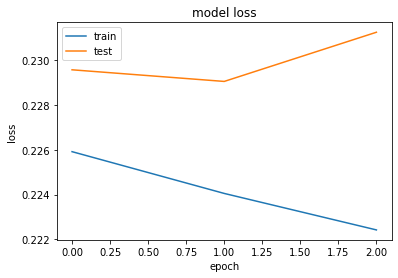

In [92]:
# summarize history for loss
import matplotlib.pyplot as plt

plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [93]:
print(model.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


In [94]:
print("Accuracy:",model.history['accuracy'])

Accuracy: [0.90901643, 0.909054, 0.9099107]


## Build the same model with attention layers included for better performance (Optional)

## Fit the model and report the accuracy score for the model with attention layer (Optional)